In [1]:
import pickle
import pandas as pd
import numpy as np

fd = open("../models/sf_model_verbs.pkl","rb")
vec = pickle.load(fd)
clf = pickle.load(fd)

In [2]:
# describe model
print("Classes:",[(name, i) for name,i in enumerate(clf.classes_)])
print("Parameters:",clf.get_params())

Classes: [(0, 'hard'), (1, 'soft')]
Parameters: {'alpha': 0.0001, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': 1000, 'n_iter_no_change': 5, 'n_jobs': None, 'penalty': 'l2', 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'tol': None, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [3]:
from htrc_features import FeatureReader
def get_htrc_page_data(document):
    fr = FeatureReader([document])
    vol = next(fr.volumes())
    ptc = vol.tokenlist(pos=True, case=False).reset_index().drop(['section'], axis=1)
    ptc = ptc[ptc["pos"] == "VB"]
    page_list = set(ptc['page'])
    
    # extract tokens by page 
    tokens=list()
    for page in page_list:
        page_data = str()
        
        # operate on each token
        for page_tokens in ptc.loc[ptc['page'] == page].iterrows():
            if page_tokens[1][1].isalpha():
                
                # deal with frequency count by creating correct number of tokens
                page_data += (' '.join([page_tokens[1][1]] * page_tokens[1][3])) + " "

        tokens.append(page_data.split())
    return tokens

# return bibliographic data
def get_htrc_metadata(document):
    fr = FeatureReader([document])
    vol = next(fr.volumes())
    return([vol.author[0],vol.title,vol.year])

In [4]:
# new testing set
test = ["mdp.39015025252100", "mdp.39015038888775", "pst.000059688501", "pst.000027847633", "mdp.39015012435791", "pst.000022355218", "mdp.39015000244775", "mdp.39015002969064", "mdp.39015046878727", "uc1.32106010337274", "mdp.39015000611528", "pst.000064238685"] 

test_labels = ['hard', 'hard', 'hard', 'hard', 'hard', 'hard', 'soft', 'soft', 'soft', 'soft', 'soft', 'soft']
testdf = pd.DataFrame([get_htrc_metadata(text) for text in test])
testdf.columns={"Author","Title","Pub Year"}
testdf['Class (Truth)'] = test_labels
testdf

,Pub Year,Author,Title,Class (Truth)
0,"Forward, Robert L.",Dragon's egg /,1980,hard
1,"Sagan, Carl, 1934-1996.",Contact : a novel /,1985,hard
2,"Asimov, Isaac, 1920-1992",Foundation.,1951,hard
3,"Huxley, Aldous, 1894-1963.",Brave new world : a novel by Aldous Huxley.,1932,hard
4,"Anderson, Poul, 1926-2001.",Tau zero /,1970,hard
5,"Gibson, William, 1948-",Neuromancer /,1986,hard
6,"Le Guin, Ursula K., 1929-2018.",The dispossessed; an ambiguous Utopia,1975,soft
7,"Lem, Stanisław.",Solaris.,1970,soft
8,"Butler, Octavia E.",Patternmaster /,1976,soft
9,"Tepper, Sheri S.",Grass /,1990,soft


In [5]:
# construct text for consumption into dtm
test_data = list()
for doc in test:
    page_data = get_htrc_page_data(doc)
    tokens = ' '.join([w for p in page_data for w in p])
    test_data.append(tokens)
test_dtm = vec.transform(test_data)

/Users/jed/miniforge3/envs/cv/lib/python3.9/site-packages/htrc_features/feature_reader.py:107: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  return df.reset_index().groupby(groups).sum()[['count']]
/Users/jed/miniforge3/envs/cv/lib/python3.9/site-packages/htrc_features/feature_reader.py:107: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  return df.reset_index().groupby(groups).sum()[['count']]
/Users/jed/miniforge3/envs/cv/lib/python3.9/site-packages/htrc_features/feature_reader.py:107: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only wil

In [6]:
predicted_labels = clf.predict(test_dtm)
testdf['Predict'] = predicted_labels
testdf

,Pub Year,Author,Title,Class (Truth),Predict
0,"Forward, Robert L.",Dragon's egg /,1980,hard,hard
1,"Sagan, Carl, 1934-1996.",Contact : a novel /,1985,hard,hard
2,"Asimov, Isaac, 1920-1992",Foundation.,1951,hard,hard
3,"Huxley, Aldous, 1894-1963.",Brave new world : a novel by Aldous Huxley.,1932,hard,soft
4,"Anderson, Poul, 1926-2001.",Tau zero /,1970,hard,hard
5,"Gibson, William, 1948-",Neuromancer /,1986,hard,soft
6,"Le Guin, Ursula K., 1929-2018.",The dispossessed; an ambiguous Utopia,1975,soft,soft
7,"Lem, Stanisław.",Solaris.,1970,soft,soft
8,"Butler, Octavia E.",Patternmaster /,1976,soft,soft
9,"Tepper, Sheri S.",Grass /,1990,soft,soft


In [7]:
from sklearn import metrics

score = metrics.accuracy_score(test_labels, predicted_labels)
# https://en.wikipedia.org/wiki/Confusion_matrix
# https://en.wikipedia.org/wiki/F-score

print("model accuracy:   %0.3f" % score)
print(metrics.classification_report(test_labels, predicted_labels))
print("confusion matrix:")
print(metrics.confusion_matrix(test_labels, predicted_labels))

model accuracy:   0.750
              precision    recall  f1-score   support

        hard       0.80      0.67      0.73         6
        soft       0.71      0.83      0.77         6

    accuracy                           0.75        12
   macro avg       0.76      0.75      0.75        12
weighted avg       0.76      0.75      0.75        12

confusion matrix:
[[4 2]
 [1 5]]


<AxesSubplot: >

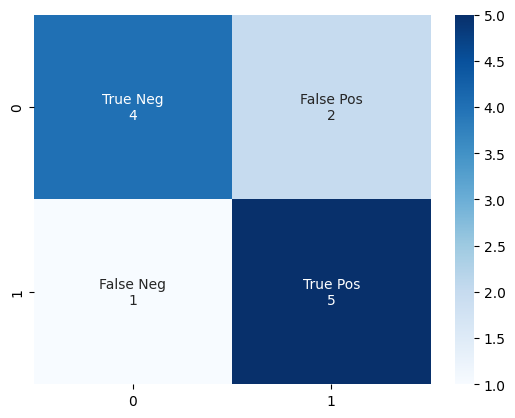

In [8]:
import seaborn as sn
cf_matrix = metrics.confusion_matrix(test_labels,predicted_labels)
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = [f"{l}\n{v}" for l, v in zip(labels,cf_matrix.flatten())]
labels = np.asarray(labels).reshape(2,2)
sn.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')